### ***Vasiliy Mosin***

There is a CNN with greedy layer-wise pretraining via Variational Convolutional AutoEncoders implemented in this notebook. 

In [2]:
import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

from mldm.net import Net

%matplotlib inline
import matplotlib.pyplot as plt

Loading of the MNIST dataset.

In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
import mnist

In [ ]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

In [4]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [5]:
def one_hot(y, n_classes=10):
    onehot = np.zeros(shape=(y.shape[0], n_classes), dtype='float32')
    onehot[np.arange(y.shape[0]), y] = 1.0
    return onehot

In [6]:
y = one_hot(y)
y_test = one_hot(y_test)

Make a little change to the DeepDenseMNISTNet class in order to create Convolutional Autoencoders.

In [21]:
class DeepDenseMNISTNet(Net):
    def __init__(self):
        self.X_batch = T.tensor4(name='X_batch')
        self.y_batch = T.fmatrix(name='y_batch')
        self.layers = []
        input_l = layers.InputLayer(shape=(None, 1, 28, 28), input_var=self.X_batch, name='Input')
        self.layers.append(input_l)
        for i, n_units in enumerate([4, 4, 4]):
            conv = layers.Conv2DLayer(self.layers[-1], n_units, (3, 3))
            self.layers.append(conv)
        output_l = layers.DenseLayer(self.layers[-1], num_units=10, nonlinearity=nonlinearities.softmax, name= 'output') 
        self.layers.append(output_l)
        self.net = output_l       
        self.predictions = layers.get_output(self.net)
        self.pure_loss = T.mean(objectives.categorical_crossentropy(self.predictions, self.y_batch))        
        self.prior_params = [theano.shared(np.zeros(shape=param.get_value().shape, dtype='float32'),
                name = 'prior%d' % i) for i, param in enumerate(layers.get_all_params(self.net, regularizable=True))]    
        self.regularizations = [T.mean((param - prior) ** 2) for param, prior in
                                zip(layers.get_all_params(self.net, regularizable=True), self.prior_params)]       
        self.regularization = reduce(lambda a, b: a + b, self.regularizations)
        self.regularization_coef = T.fscalar('regularization_coef')        
        self.loss = self.pure_loss + self.regularization_coef * self.regularization        
        self.learning_rate = T.fscalar('learning rate')
        params = layers.get_all_params(self.net)
        upd = updates.adadelta(self.loss, params, learning_rate=self.learning_rate)
        self.train = theano.function([self.X_batch, self.y_batch, self.regularization_coef, self.learning_rate],
                                     self.pure_loss, updates=upd)
        self.get_loss = theano.function([self.X_batch, self.y_batch], self.pure_loss)
        super(DeepDenseMNISTNet, self).__init__()
    
    def copy_as_prior(self):
        for param, prior in zip(layers.get_all_params(self.net, regularizable=True), self.prior_params):
            value = param.get_value()
            prior.set_value(value)
            
    def save(self, path):
        params = layers.get_all_param_values(self.net)
        priors = [ prior.get_value() for prior in self.prior_params ]
        p = dict()
        for i, v in enumerate(params):
            p['param_%d' % i] = v
        for i, v in enumerate(priors):
            p['prior_%d' % i] = v
        return np.savez(path, **p)
    
    def load(self, path):
        with np.load(path) as f:
            params = layers.get_all_params(self.net)
            param_values = [ f['param_%d' % i] for i in xrange(len(params)) ]
            layers.set_all_param_values(self.net, param_values)
            for i, prior in enumerate(self.prior_params):
                prior.set_value(f['prior_%d' % i])
        return self
            
    @staticmethod
    def batch_stream(n, batch_size=32):
        n_batches = n / batch_size
        for i in xrange(n_batches):
            indx = np.random.choice(n, size=batch_size)
            yield indx
    
    def fit(self, X, y, n_epoches = 1, batch_size=32, regularization_coef=1.0e-3, learning_rate = 1.0):
        regularization_coef = np.float32(regularization_coef)
        learning_rate = np.float32(learning_rate)
        n_batches = X.shape[0] / batch_size
        losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
        for epoch in xrange(n_epoches):
            #print epoch
            for i, indx in enumerate(self.batch_stream(X.shape[0], batch_size=batch_size)):
                losses[epoch, i] = self.train(X[indx], y[indx], regularization_coef, learning_rate)
            yield losses[:(epoch + 1)]

In [22]:
deep_net = DeepDenseMNISTNet()

In [23]:
deep_net.save('deep-net-0.npz')

In [ ]:
lozz = []
for loss in deep_net.fit(X, y, n_epoches=8, batch_size=512, regularization_coef=1.0e-3):
    lozz.append(loss.mean())

Plotting training curve without pretraining.

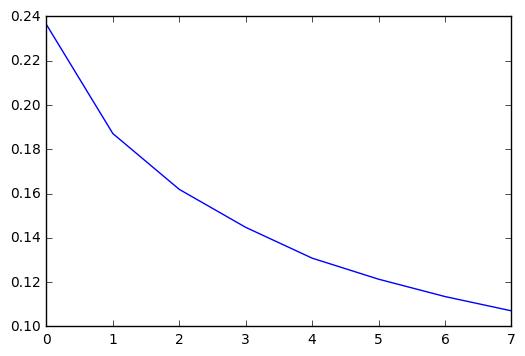

In [27]:
plt.plot(lozz)

Now, compare it with pretrained network.

In [28]:
deep_net = deep_net.load('deep-net-0.npz')

In [29]:
class VAE(Net):
    def __init__(self, layer, X_input, p = 0.1):
        super(VAE, self).__init__()      
        X_in = layers.get_output(layer.input_layer)
        in_shape = layer.input_shape
        out_shape = layer.output_shape      
        self.in_layer = layers.InputLayer(shape=in_shape, input_var=X_in)
        self.dropout_l = layers.DropoutLayer(self.in_layer, p = p, rescale=False)
        self.encode_l = layers.Conv2DLayer(self.dropout_l, out_shape[1], (3,3), W = layer.W, b = layer.b)
        self.decode_l = layers.Deconv2DLayer(self.encode_l, in_shape[1], (3,3))
        self.net = self.decode_l
        reconstructed = layers.get_output(self.decode_l)
        self.reconstructed = reconstructed
        self.loss = -T.mean(X_in * T.log(reconstructed) + (1 - X_in) * T.log(1 - reconstructed))
        params = layers.get_all_params(self.net)
        learning_rate = T.fscalar('learning rate')
        upd = updates.adadelta(self.loss, params, learning_rate=learning_rate)
        self.train = theano.function([X_input, learning_rate], self.loss, updates=upd, allow_input_downcast=True)

    @staticmethod
    def batch_stream(n, batch_size=32):
        n_batches = n / batch_size
        for i in xrange(n_batches):
            indx = np.random.choice(n, size=batch_size)
            yield indx
    
    def fit(self, X, n_epoches = 1, batch_size=32, learning_rate = 1.0):
        learning_rate = np.float32(learning_rate)
        n_batches = X.shape[0] / batch_size
        losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
        for epoch in xrange(n_epoches):
            #print epoch
            for i, indx in enumerate(self.batch_stream(X.shape[0], batch_size=batch_size)):
                losses[epoch, i] = self.train(X[indx], learning_rate)
            yield losses[:(epoch + 1)]

Pretraining loop.

In [ ]:
for i, l in enumerate(deep_net.layers[1:len(deep_net.layers)-1]):
    vae = VAE(l, p=0.25, X_input=deep_net.X_batch)
    lozz = []
    for l in vae.fit(X, n_epoches=8, batch_size=512, learning_rate=1.0):
        lozz.append(l.mean())
    #deep_net.copy_as_prior()
    #deep_net.save('deep-net-%d.npz' % (i + 1))

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


Fine-tuning.

In [ ]:
deep_net.load('deep-net-2.npz')

In [20]:
lozz = []
for l in deep_net.fit(X, y, n_epoches=8, batch_size=512, learning_rate=1.0e-1, regularization_coef=1.0e-2):
    lozz.append(l.mean())

In [ ]:
plt.plot(lozz)

As we see, training goes faster in case of using VAE as pretraining.

Calculation of the final accuracy.

In [22]:
predict = theano.function([deep_net.X_batch], deep_net.predictions)

In [23]:
y_proba = predict(X_test)
print 'accuracy:', np.mean(np.argmax(y_test, axis=1) == np.argmax(y_proba, axis=1))

accuracy: 0.9819
